# Assignment - Week 1

## Steps:
1. Create circuit and apply gates
2. Execute circuit (with Aer simulator and on real IBM quantum hardware)
3. Plot histogram

## References
1. [IBM Quantum Hello World guide](https://docs.quantum.ibm.com/guides/hello-world)
2. [`SamplerV2` API docs](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.SamplerV2#samplerv2)
3. [`AerSimulator` examples](https://docs.quantum.ibm.com/guides/local-testing-mode#aersimulator-examples)
4. [`QuantumCircuit` API docs](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit)

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector

from qiskit_aer.primitives import SamplerV2 as AerSampler
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit.visualization import plot_histogram

%matplotlib inline

## Explanation of algorithm
All steps have been seperated by barriers in below diagram
1. Store the state to teleported $C$ or $\ket{\psi}$ in $q_0$
   
2. Prepare a Bell state, $\ket{\Phi^+} = \frac{\ket{00} + \ket{11}}{\sqrt{2}}$, between Alice ($q_1$) and Bob ($q_2$)
   
3. Total 3-qubit state can be written with qubits $q_0 q_1$ in 2-qubit x-basis as:
   $$
   \frac{1}{2} \left( \ket{\Phi^+} \otimes (\alpha\ket{0} + \beta\ket{1}) +
   \ket{\Phi^-} \otimes (\alpha\ket{0} - \beta\ket{1}) +
   \ket{\Psi^+} \otimes (\alpha\ket{1} + \beta\ket{0}) +
   \ket{\Psi^-} \otimes (\alpha\ket{1} - \beta\ket{0}) \right)
   $$
   We convert $q_0 q_1$ to z-basis by applying $CX$ and $H$ gates.

4. Measure $q_0 q_1$ in the z-basis as:
   $$\ket{\Phi^+} \xrightarrow{CX} \xrightarrow{H} \ket{00}$$
   $$\ket{\Phi^-} \xrightarrow{CX} \xrightarrow{H} \ket{01}$$
   $$\ket{\Psi^+} \xrightarrow{CX} \xrightarrow{H} \ket{10}$$
   $$\ket{\Psi^-} \xrightarrow{CX} \xrightarrow{H} \ket{11}$$

5. Based on the measurements apply $X$ and/or $Z$ gate on Bob's qubit $q_2$:<br>
   $0,0 \implies$ No change<br>
   $0,1 \implies$ Apply $X$<br>
   $1,0 \implies$ Apply $Z$<br>
   $1,1 \implies$ Apply $X$ and $Z$
   
6. State $\ket{\psi}$ has been teleported to $q_2$, now take final measurement for sampling.

Here, $\alpha = 0.6$, $\beta = 0.8$ for illustration

![Diagram of circuit](./quantum-teleportation-circuit.png)

### Reference
https://en.wikipedia.org/wiki/Quantum_teleportation#Formal_presentation

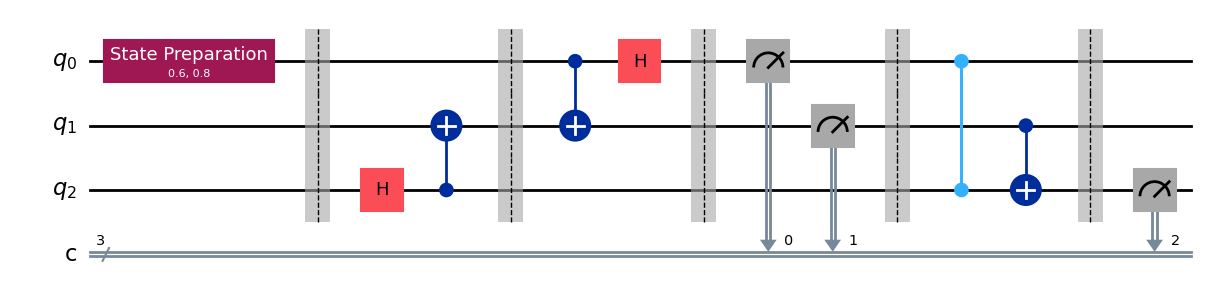

In [36]:
### Setup the quantum circuit with 3 qbits and 3 clbits
qbits = QuantumRegister(3, "q")
clbits = ClassicalRegister(3, "c")
qc = QuantumCircuit(qbits, clbits)

# currently all 3 qbits are in ∣0⟩ state

### Prepare q0 in the 0.6∣0⟩ + 0.8∣1⟩ state (to be teleported)

# the state to be used for teleportation as statevector
psi = Statevector([0.6, 0.8])

qc.prepare_state(psi, 0)
qc.barrier()

### Prepare bell state q1 ⊗ q2 = (∣00⟩ + ∣11⟩) / √2

qc.h(2) # hadamard on q2
qc.cx(2, 1) # CNOT from q2 to q1
qc.barrier()

### Map q0 ⊗ q1 from Bell basis to the computational basis using cx and h gates

qc.cx(0, 1) # CNOT from q0 to q1
qc.h(0) # hadamard on q0
qc.barrier()

### Measure (in computational basis) q0 and q1
qc.measure(0, 0)
qc.measure(1, 1)
qc.barrier()

### Apply Z on q2 if q0 measured as ∣1⟩
qc.cz(0, 2)

### Apply X on q2 if q1 measured as ∣1⟩ 
qc.cx(1, 2)
qc.barrier()

### Finally measure q2 (this is the result we wish to sample)
qc.measure(2, 2)

# draw circuit
fig = qc.draw('mpl')



## Note on executing circuit (reference 1)

With qiskit >1.0, circuits can be executed using  primitives, which are of two types: first is `Estimator` classes which measure expectation value of observables consisting of Pauli `I, X, Y, Z` operators or, using `Sampler` classes which give counts of various states by sampling the measurements multiple times.

Here, I am using the `SamplerV2` since it is better suited for directly measuring the state and allows faster, efficient execution for this particular case.

For Aer simulator I use `qiskit_aer.primitives.SamplerV2` and for running on IBM hardware I use `qiskit_ibm_runtime.SamplerV2`.

## Note on calculating `counts` and `probabilities` from `result`

Result data is accessed by `job.result()[0].data[creg_name].get_bitstrings()` which returns a list of all bitstrings received in each sample run of the circuit.

The first bit (LSB) refers to the last classical bit which is the actual measurement we need. I use `sum(1 for state in bitstrings if state[0] == i)` to get the number of bitstrings where first bit is `i`

Then it is divided by `shots` to get the probability in `[0, 1]`

## Note on histogram

Histogram is plotted for `counts` but it is not clear what the ratio is. For that a plot of `probabilities` is also shown.

### Reference
[Getting started with primitives | IBM Quantum](https://docs.quantum.ibm.com/guides/get-started-with-primitives)

In [40]:
def execute_circuit(qc: QuantumCircuit, sampler, shots: int, creg_name = None):
    '''
    Helper function for running given circuit, given a sampler object and other args
    
    Returns:
        Tuple of counts, probabilities, fig_counts, fig_probabilities
    '''

    # name of the classical bits register where measurements are made
    if creg_name is None:
        creg_name = qc.cregs[0].name
    
    # apparently this fixes the error: 'The instruction u on qubits (32,) is not supported by the target system'
    _ = qc.data
    
    # run job
    job = sampler.run([qc], shots=shots)
    print(f"Job Id: {job.job_id()}")
    print()

    # get result as bitstrings received in each
    result = job.result()
    bitstrings = result[0].data[creg_name].get_bitstrings()

    # see above note
    counts = {i: sum(1 for state in bitstrings if state[0] == i) for i in '01'}
    probabilities = {i: counts[i] / shots for i in counts}
    
    # print results
    print(f"Counts: {counts}")
    print(f"Probabilities: {probabilities}")
    
    # plot histograms
    fig_c = plot_histogram(counts)
    fig_p = plot_histogram(probabilities)
    
    return (counts, probabilities, fig_c, fig_p)

## Aer Simulator execution
`AerSampler` object is initialized and circuit is *decomposed* to make it compatible with `AerSampler`

Job Id: a9f360bf-28ab-40bc-aae3-a74b1c32af1f

Counts: {'0': 1428, '1': 2668}
Probabilities: {'0': 0.3486328125, '1': 0.6513671875}


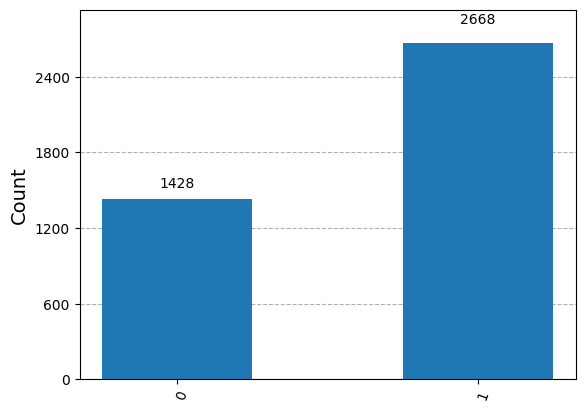

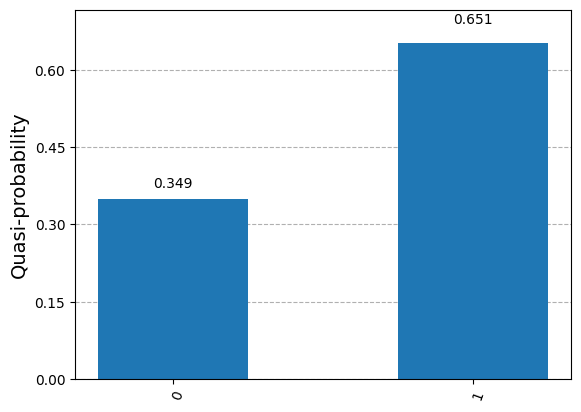

In [41]:
aer_sampler = AerSampler()
shots = 4096
decomposed_circuit = qc.decompose(reps=6)

aer_counts, aer_probabilities, _, _ = execute_circuit(decomposed_circuit, aer_sampler, shots, 'c')

## IBM Quantum Hardware execution

Call runtime service and invoke the least busy backend (from reference 1)

In [29]:
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
print(f"Using '{backend.name}'")

Using 'ibm_brisbane'


Create `SamplerV2` object.

Transpile the circuit for the required backend using `generate_preset_pass_manager` (from reference 1) to the conform to the backend devices [Instruction Set Architecture (ISA)](https://docs.quantum.ibm.com/guides/transpile#instruction-set-architecture).

And draw the transpiled circuit

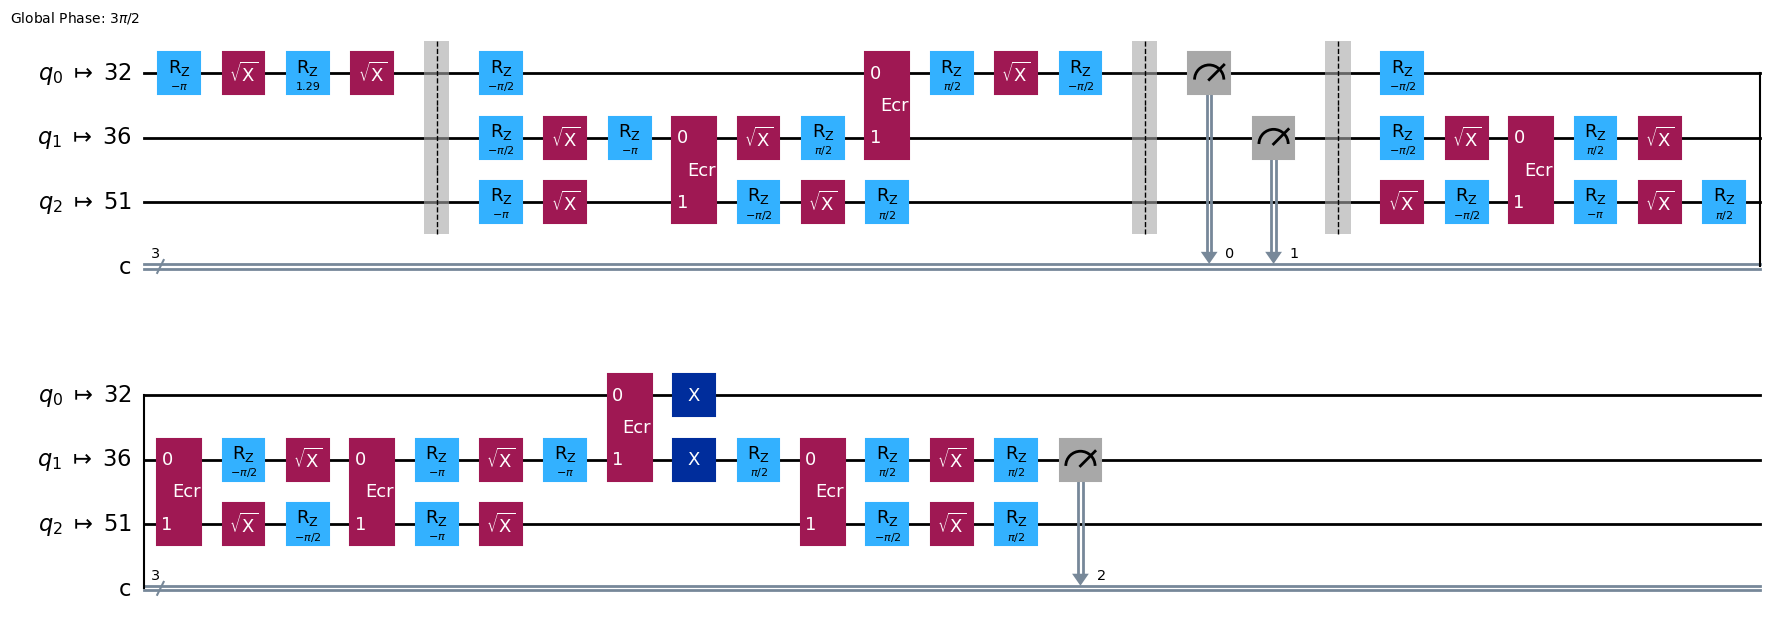

In [30]:
shots = 4096
ibmq_sampler = Sampler(backend)

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
fig = isa_circuit.draw('mpl', idle_wires=False)

Job Id: cxe5vfxfdnwg008s4da0

Counts: {'0': 1508, '1': 2588}
Probabilities: {'0': 0.3681640625, '1': 0.6318359375}


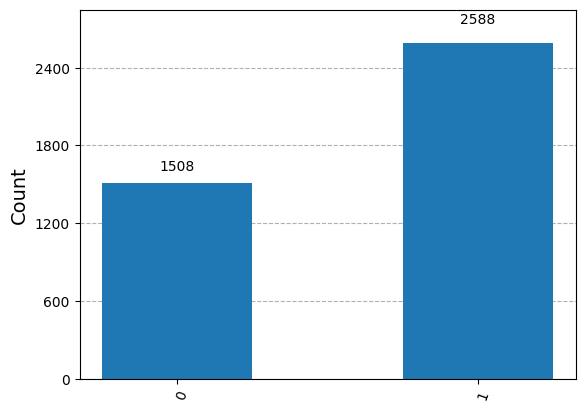

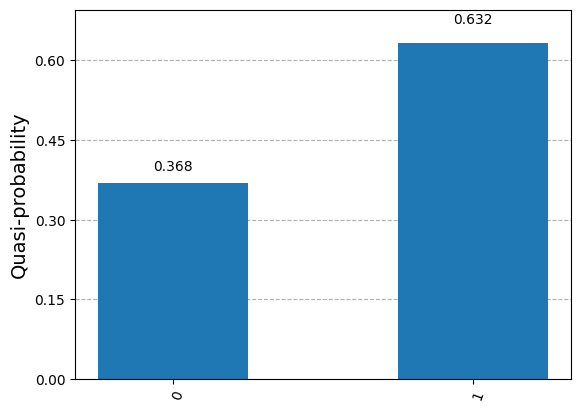

In [ ]:
ibmq_counts, ibmq_probabilities, _, _ = execute_circuit(isa_circuit, ibmq_sampler, shots, 'c')

## Analysis

Ideally, the quantum circuit should produce the state $q_2 = 0.6\ket{0} + 0.8\ket{1}$, so the probabilities should be very close to $0.36$ and $0.64$ for measurement $0$, $1$ respectively (probability is equal to modulus squared of the amplitude).

### Aer-based execution
In the Aer-based execution, the simulator can store the exact statevectors after every unitary gate operation. When the first two measurements are made, the combined two-qubit state collapses to one of the 4 computational basis states with equal probability, but their statevectors can no longer be described. This is where the `StatevectorSimulator` fails (hence the reason why it cannot be used).

Still, this does not introduce any error since the qubits were already entangled. So, the final state of $q_2$ is still exactly what is expected from the quantum circuit.

When the final measurement is made, the state must collapse to one of the two computational basis states with precisely the probabilities $0.36$ and $0.64$. However, this is where we may get slight mismatch in final values due to "chance" because of finite number of shots. As we increase number of shots results will become more accurate.

### Real quantum hardware execution
When it is executed on real quantum hardware, there are many sources of error:
1. Error in preparing the initial $\ket{\psi}$ state
2. Imperfections in gates
3. Decoherence of the entangled states over the duration of circuit execution
4. Environmental noise

This introduces an additional error in the final $q_2$ state which is not present in Aer-based execution. Finally, the measurement will also be less accurate due to finite number of shots.

## Note
Moreover, this method of sampling the measurement results is not most appropriate because the final $q_2$ state may have a change in its phase ($0.6\ket{0} + 0.8 e^{i\phi} \ket{1}, \; 0 \leq \phi \leq 2\pi$) will keeping probabilities the same, but this may also contribute positively to the accuracy of the result.

So, most appropriate method would be construct an observable of the form projector $P = \ket{\psi}\bra{\psi}$ and use `Estimator` class to measure its expectation value (values close $+1$ indicate strong correlation).

In [1]:
def rel_percent_error(expec, real):
    return {'0': abs(expec['0'] - real['0']) / expec['0'] * 100, '1': abs(expec['1'] - real['1']) / expec['1'] * 100}

expected = {'0': 0.36, '1': 0.64}

print("Rel % error in Aer probabilities:", rel_percent_error(expected, aer_probabilities))
print("Rel % error in IBMQ probabilities:", rel_percent_error(expected, ibmq_probabilities))

NameError: name 'aer_probabilities' is not defined